# Application: Stability of Planetary Systems

Planetary systems are an example of a few-body problem --- each planet exerts a gravitational force on the others, in addition to the dominant gravitation influence of the central star.  If the planets get too close, then collisions or ejections can occur.

## Hill radius

An important concept in plantary dynamics is the *mutual Hill radius*, $R_h$, which measures how much one planet affects another through their gravitational attraction at closest encounter:

$$R_h = \frac{a_1 + a_2}{2} \left ( \frac{M_1 + M_2}{3 M_\star} \right )^{1/3}$$

where $a_1$ and $a_2$ are the radii of the planet orbits and $M_1$ and $M_2$ are their masses
(this is closely related to the [Hill sphere](https://en.wikipedia.org/wiki/Hill_sphere)) and we define the separation between planets 1 and 2 (in circular orbits).

The separation between to planets relative to their hill radius is:

$$\Delta = \frac{a_2 - a_1}{R_h}$$

(assuming $a_2 > a_1$).

For a system with 2 planets, it turns out that the orbits are stable as long as $\Delta \gtrsim 3.5$ (see, e.g., [Gladman 1993](https://ui.adsabs.harvard.edu/abs/1993Icar..106..247G/abstract)).  For more than 2 planets, there is no simple constraint on $\Delta$, but less massive planets with larger spacings tend to be more stable, and the stability criteria depends on how long you want the system to remain stable (see, e.g., [Smith & Lissauer 2009](https://ui.adsabs.harvard.edu/abs/2009Icar..201..381S/abstract), [Morrison & Kratter 2016](https://iopscience.iop.org/article/10.3847/0004-637X/823/2/118)).

We will attempt to model the stability of a system like [HR 8799](https://en.wikipedia.org/wiki/HR_8799).  A recent investigation of this system was done in [Götberg et al. 2016](https://www.aanda.org/articles/aa/full_html/2016/08/aa26309-15/aa26309-15.html) which found many configurations are unstable to the estimated age of this explanetary system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class State:
    """a container to hold an object"""

    def __init__(self, mass, x, y, u, v):
        self.mass = mass
        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __str__(self):
        return f"{self.mass:10.6f}: {self.x:10.6f} {self.y:10.6f} {self.u:10.6f} {self.v:10.6f}"

In [3]:
import collections

## Integrator

We will implement the 4th order sympletic integrator of [Yoshida 1990](https://ui.adsabs.harvard.edu/abs/1990PhLA..150..262Y/abstract) (see also [Wikipedia's leapfrong article](https://en.wikipedia.org/wiki/Leapfrog_integration#Yoshida_algorithms)).  This follows
the same ideas as the velocity-Verlet method --- there is a sequemce of drifts and kicks
arranged to make the truncation error $\mathcal{O}(\Delta t^4)$.

```{note}
We work in units of solar masses, astronomical units, and years.
```

In setting up our solar system, we require the mass of the star and the semi-major axes and masses of the planets.  We will use circular orbits for the planets, with the initial position given a random angle about the Sun (the `seed` parameter sets the random number generator seed).

```{important}
We want our system to be at rest and for the barycenter to be at the origin, so once we initialize the planets, we compute the center of mass and momentum and adjust the star's position and velocity to ensure that the center of mass is at the origin and stationary.
This has the side-effect that the planet orbits now have a small initial eccentricity.
```

Our integrator will only store the last `max_history` positions of the planets, since matplotlib can have trouble with really long integration histories.  We also will stop the integration if any of the planets gains a distance from the origin larger than `escape_radius`.

Close encounters can be problematic.  One approach is to switch from using a sympletic integrator to a high-order time-adaptive integrator with error-control once two planets become closer than a few Hill radii (see, e.g., [Chatterjee et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJ...686..580C/abstract)).

In [14]:
class SolarSystem:
    """model the gravitational interaction of a solar system."""

    def __init__(self, M_star, *, m_planets=None, a_planets=None,
                 max_history=50000, SMALL=1.e-30,
                 seed=1234, escape_radius=10000):

        # initialize the random number generator
        np.random.seed(seed)

        # Yoshida integrator constants
        cbrt2 = np.cbrt(2)
        w0 = -cbrt2 / (2 - cbrt2)
        w1 = 1 / (2 - cbrt2)

        self.c = np.array([w1 / 2, 0.5 * (w0 + w1), 0.5 * (w0 + w1), w1 / 2])
        self.d = np.array([w1, w0, w1])

        self.G = 4 * np.pi**2  # units AU**3 / (solar mass * year**2)
        self.M_star = M_star

        self.escape_radius = escape_radius
        self.a_initial = [0] + a_planets
        
        # store the history of the solar system
        self.history = collections.deque(maxlen=max_history)

        # we have the star and planets
        self.nobjects = len(m_planets) + 1
        
        # current solar system
        system = []
        
        # store the star 
        system.append(State(M_star, 0.0, 0.0, 0.0, 0.0))

        # store the planets
        assert len(m_planets) == len(a_planets)

        for m, a in zip(m_planets, a_planets):
            # pick a random angle and then set the velocity to be circular
            phi = np.random.uniform(0, 2.0*np.pi)
            v_circ = np.sqrt(self.G * self.M_star / a)
            system.append(State(m,
                                a*np.cos(phi), a*np.sin(phi),
                                -v_circ*np.sin(phi), v_circ*np.cos(phi)))
        
        # now correct the star's state so the center of mass is stationary
        # and at the origin
        system[0].x = -sum(s.mass * s.x for n, s in enumerate(system) if n != 0) / M_star
        system[0].y = -sum(s.mass * s.y for n, s in enumerate(system) if n != 0) / M_star
        system[0].u = -sum(s.mass * s.u for n, s in enumerate(system) if n != 0) / M_star
        system[0].v = -sum(s.mass * s.v for n, s in enumerate(system) if n != 0) / M_star

        # store the initial state
        self.history.append(system)

        self.SMALL = SMALL

        self.time = collections.deque([0.0], maxlen=max_history)

        h = self.compute_hill_separation(system)
        print(f"initial minimum relative separation / Hill radius = {h.min()}")
    
    def npts(self):
        """return the number of integration points"""
        return len(self.time)

    def compute_hill_separation(self, state):
        """compute the multiual Hill radius for each pair of planets"""
        h_sep = np.zeros((self.nobjects, self.nobjects))
        h_sep[:, :] = np.inf
        
        # loop over the planets
        for p1 in range(1, self.nobjects):
            a1 = np.sqrt((state[p1].x - state[0].x)**2 +
                         (state[p1].y - state[0].y)**2)   
            for p2 in range(1, self.nobjects):
                if p1 == p2:
                    continue
                a2 = np.sqrt((state[p2].x - state[0].x)**2 +
                             (state[p2].y - state[0].y)**2)
                r_hill = 0.5 * (a1 + a2) * np.cbrt((state[p1].mass +
                                                    state[p2].mass) /
                                                   (3 * self.M_star))
                h_sep[p1, p2] = np.abs(a2 - a1) / r_hill
                h_sep[p2, p1] = h_sep[p1, p2]

        return h_sep
        
    def rhs(self, states):
        """states is (State, State, ...)"""

        ydots = []

        for iobj in range(len(states)):

            # compute the space derivatives

            dxdt = states[iobj].u
            dydt = states[iobj].v

            # compute the velocity derivatives
            dudt = 0.0
            dvdt = 0.0

            for jobj in range(len(states)):
                if iobj == jobj:
                    continue
                else:
                    dx = states[jobj].x - states[iobj].x
                    dy = states[jobj].y - states[iobj].y

                    r = np.sqrt(dx**2 + dy**2) + self.SMALL

                    dudt += self.G * states[jobj].mass * dx / r**3
                    dvdt += self.G * states[jobj].mass * dy / r**3

            ydots.append(State(states[iobj].mass, dxdt, dydt, dudt, dvdt))

        return ydots

    def single_step_yoshida(self, states_old, dt):
        """take a single step using the 4th order Yoshida integrator"""

        # we can just work on the "new" state directly, so start by
        # copying the old to new
        states_new = []
        for s in states_old:
            states_new.append(State(s.mass, s.x, s.y, s.u, s.v))
            
        # drift with current velocity
        for s in states_new:
            s.x += self.c[0] * s.u * dt
            s.y += self.c[0] * s.v * dt

        for i in range(3):
            # evaluate the force
            ydots = self.rhs(states_new)
        
            # kick followed by drift
            for n, s in enumerate(states_new):
                s.u += self.d[i] * ydots[n].u * dt
                s.v += self.d[i] * ydots[n].v * dt

                s.x += self.c[i+1] * s.u * dt
                s.y += self.c[i+1] * s.v * dt

        return states_new

    def integrate(self, dt, tmax):
        """integrate our solar system using the velocity-Verlet method"""

        t = self.time[-1]
        escaped = False
        while t < tmax and not escaped:
            
            states_old = self.history[-1]

            if t + dt > tmax:
                dt = tmax-t

            states_new = self.single_step_yoshida(states_old, dt)

            t += dt
            
            self.time.append(t)
            self.history.append(states_new)

            # check if any planet has escaped
            for n, s in enumerate(states_new):
                if n == 0:
                    continue
                if np.sqrt(s.x**2 + s.y**2) > self.escape_radius:
                    print(f"planet {n} escaped!")
                    escaped = True
                    
    def plot(self, draw_original_orbits=True):
        fig, ax = plt.subplots()

        if draw_original_orbits:
            theta = np.radians(np.arange(361))
            for n in range(self.nobjects):
                ax.plot(self.a_initial[n]*np.cos(theta),
                        self.a_initial[n]*np.sin(theta),
                        ls=":", color=f"C{n}")

        for n in range(self.nobjects):
                    
            xs = [q[n].x for q in self.history]
            ys = [q[n].y for q in self.history]
            if n == 0:
                label = "*"
            else:
                label = f"planet {n}"
            ax.plot(xs, ys, color=f"C{n}", label=label)

        ax.axis("equal")
        ax.legend(fontsize="small")
        return fig

## First integration test

We'll start with only 3 planets in the system.  These are picked such that the initial $\Delta > 3$ for the system.

In [15]:
# the system seems stable if we omit planet 3
m_planets = [0.0054, 0.0074, 0.0071]
a_planets = [71.6, 41.4, 16.3]


In [16]:
s = SolarSystem(1.5, m_planets=m_planets, a_planets=a_planets,
                escape_radius=1000)

initial minimum relative separation / Hill radius = 3.778998530885095


In [17]:
for o in s.history[0]:
    print(o)

  1.500000:   0.125746  -0.128205   0.002400   0.011411
  0.005400:  25.720964  66.820596  -0.848724   0.326696
  0.007400: -29.801160 -28.737621   0.830187  -0.860911
  0.007100: -15.068147   6.216185  -0.726889  -1.761992


In [18]:
s.integrate(0.05, 50000)

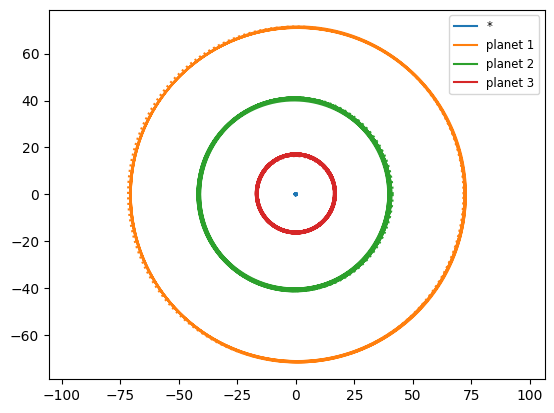

In [19]:
fig = s.plot()

## HR 8799 analogue

Now we'll add the 4th planet, giving us a system that approximates HR 8799.

In [10]:
# these are roughly the HR 8799 planet orbits
m_planets = [0.0054, 0.0074, 0.0087, 0.0071]
a_planets = [71.6, 41.4, 26.7, 16.3]

initial minimum relative separation / Hill radius = 2.787501730226769
planet 3 escaped!


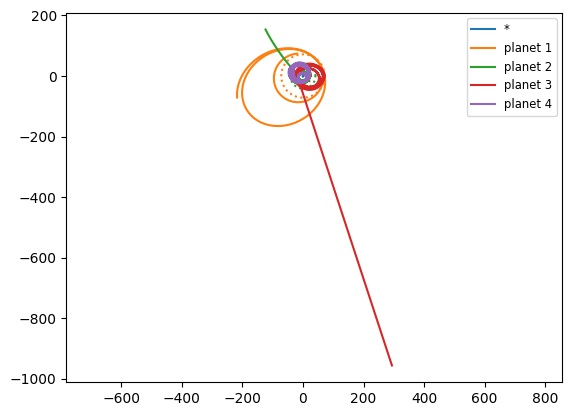

In [11]:
s = SolarSystem(1.5, m_planets=m_planets, a_planets=a_planets,
                escape_radius=1000)
s.integrate(0.05, 50000)
fig = s.plot()

We can try different seeds, but the systems seem to always become unstable

initial minimum relative separation / Hill radius = 2.8570026966331477
planet 2 escaped!


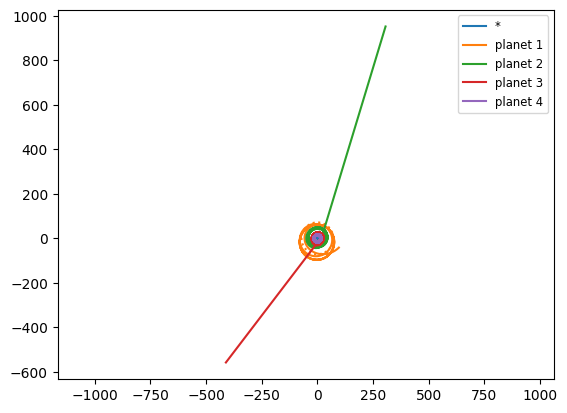

In [12]:
s = SolarSystem(1.5, m_planets=m_planets, a_planets=a_planets,
                escape_radius=1000, seed=1)
s.integrate(0.05, 50000)
fig = s.plot()

## Increasing the spacing

Let's try with the same number of planets and masses, but we'll increase the spacing a bit

initial minimum relative separation / Hill radius = 3.3947859294168876


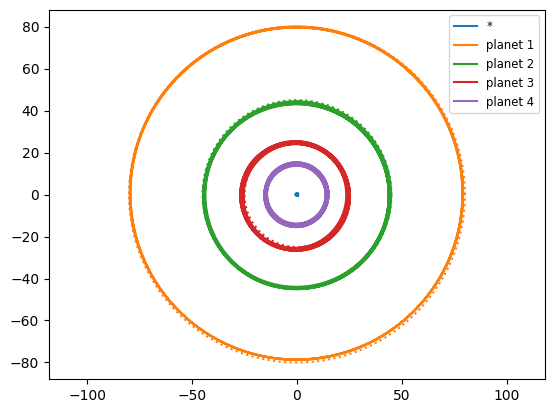

In [13]:
m_planets = [0.0054, 0.0074, 0.0087, 0.0071]
a_planets = [80, 45, 25, 15]

s = SolarSystem(1.5, m_planets=m_planets, a_planets=a_planets,
                escape_radius=1000)
s.integrate(0.05, 50000)
fig = s.plot()